# ML on ESDC using scikit-learn 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library scikit-learn. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

**This notebook runs needs a python conda environment with scikit-learn installed, please checkout the documentation for help on [changing the environment](https://deepesdl.readthedocs.io/en/v2022.12.1/guide/jupyterlab/).**

### Import necessary libraries

In [1]:
import mlflow
import numpy as np
import pandas as pd
import dask.array as da
from global_land_mask import globe
from xcube.core.store import new_data_store
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LinearSegmentedColormap

### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset    = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')

# Smaller cube for demo case
start_time = "2002-05-21"
end_time   = "2002-08-01"
ds         = dataset[["land_surface_temperature", "air_temperature_2m"]].sel(time=slice(start_time, end_time))
ds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "filter_mask". A costume name can be specified. The resulting cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "filter_mask"). 

In [3]:
from ml4xcube.preprocessing import assign_mask

lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0                = da.from_array(globe.is_land(lat_grid, lon_grid))
xdsm               = assign_mask(ds, lm0) 
xdsm

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    filter_mask               (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice

In [4]:
ds_slice = xdsm.sel({"time" : "2002-05-21"})
ds_slice

<xarray.Dataset>
Dimensions:                   (lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
    time                      datetime64[ns] 2002-05-21
Data variables:
    land_surface_temperature  (lat, lon) float32 dask.array<chunksize=(270, 270), meta=np.ndarray>
    air_temperature_2m        (lat, lon) float32 dask.array<chunksize=(270, 270), meta=np.ndarray>
    filter_mask               (lat, lon) bool dask.array<chunksize=(270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Air Temperature

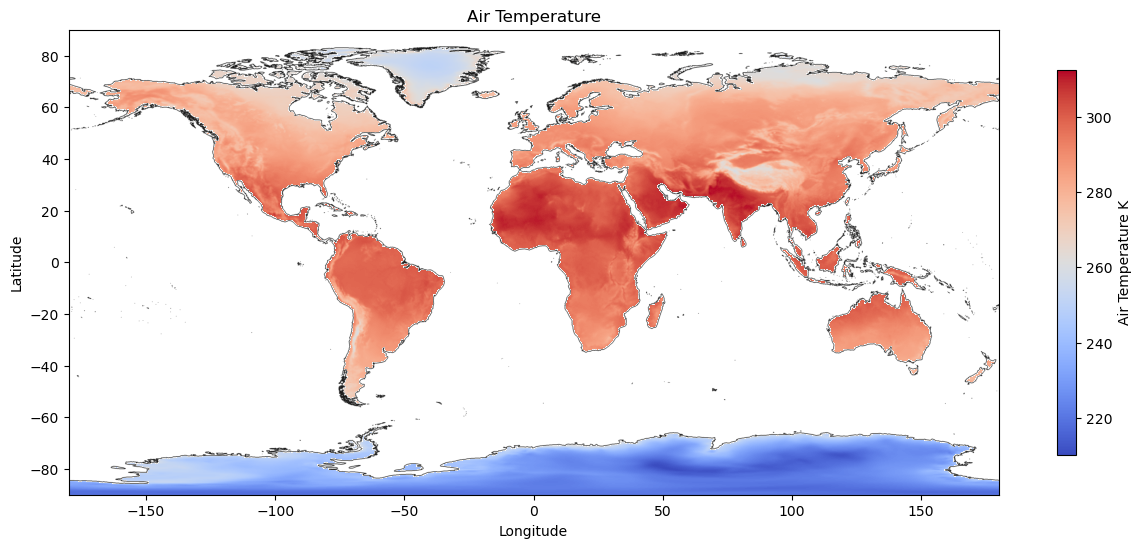

In [5]:
from ml4xcube.plotting import plot_slice

plot_slice(
    ds          = ds_slice,
    var_to_plot = "air_temperature_2m",
    xdim        = "lon",
    ydim        = "lat",
    color_map   = "coolwarm",
    title       = "Air Temperature",
    label       = "Air Temperature K"
)

Land Surface Temperature

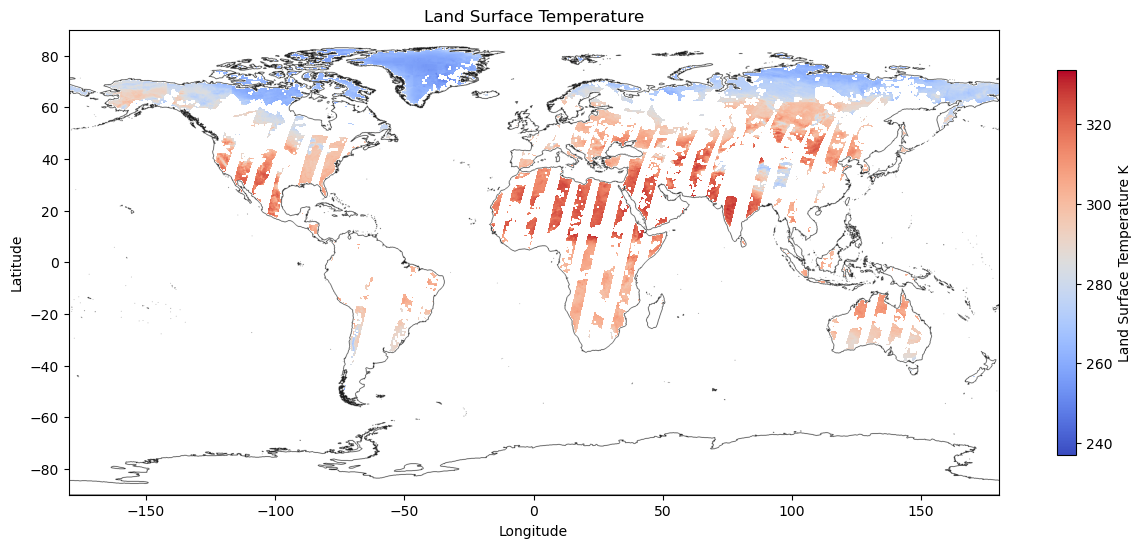

In [6]:
from ml4xcube.plotting import plot_slice

plot_slice(
    ds          = ds_slice,
    var_to_plot = "land_surface_temperature",
    xdim        = "lon",
    ydim        = "lat",
    color_map   = "coolwarm",
    title       = "Land Surface Temperature",
    label       = "Land Surface Temperature K"
)

### Train/Test Split assignment
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [7]:
from ml4xcube.splits import assign_rand_split, assign_block_split

# random sampling
xds = assign_rand_split(
    ds    = xdsm,
    split = 0.7
)

# block sampling
#xds = assign_block_split(
#    ds         = xdsm,
#    block_size = [("time", 10), ("lat", 100), ("lon", 100)],
#    split      = 0.8
#)
xds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    filter_mask               (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

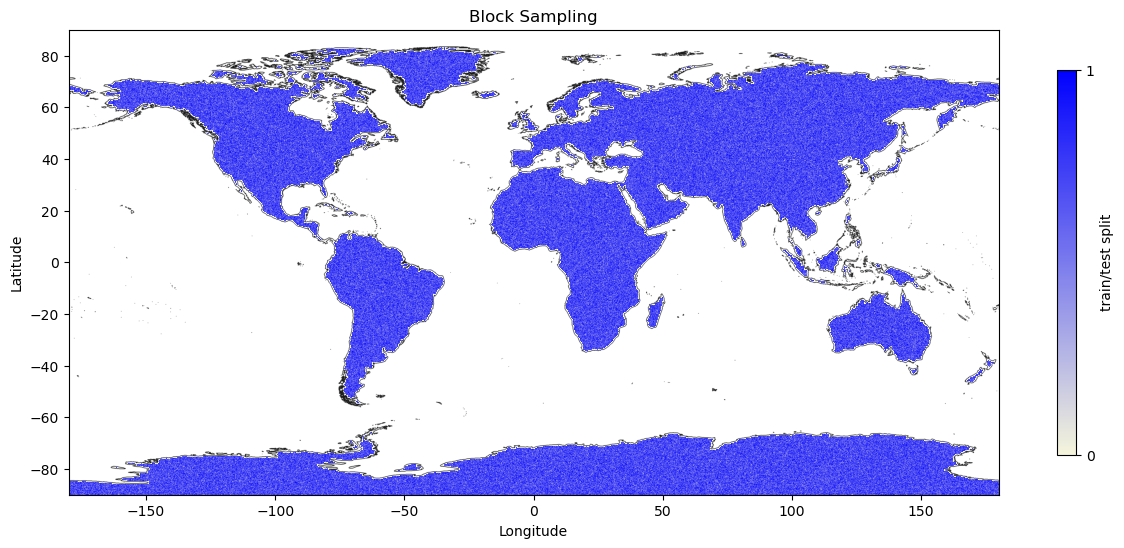

In [8]:
from ml4xcube.plotting import plot_slice

ds_slice = xds.sel({"time" : "2002-05-21"})
ds_slice = ds_slice.rename({"split": "plot_split"})

color_map = LinearSegmentedColormap.from_list("", ["beige","blue"])

plot_slice(
    ds          = ds_slice,
    var_to_plot = "plot_split",
    xdim        = "lon",
    ydim        = "lat",
    color_map   = color_map,
    title       = "Block Sampling",
    label       = "train/test split",
    ticks       = [0,1]
)

### Initialize MLFlow experiment

In [9]:
experiment_name = "Sklearn Linear Regression of LST from AT with mlflow"
mlflow.set_experiment(experiment_name)

current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id = current_experiment["experiment_id"]

run_name = "ESDC_LR_rnd"
mlflow.sklearn.autolog()

### Train-/ and Test Set Creation and Preprocessing

We utilize the `sampler` class to process and split the Earth System Data Cube (ESDC) dataset into manageable chunks. This involves several key preprocessing steps, including flattening the data, handling missing values (NaNs), and optionally applying normalization or standardization techniques. The `sampler` is also responsible for dividing the dataset into training and testing subsets based on specified chunk indices, making it easier to train and evaluate models effectively.

In this example, we configure the `XrDataset` class from `ml4xcube.datasets.xr_dataset` to extract specific chunks from the dataset, where each chunk is identified by an index. These chunks are then split into training and testing datasets, targeting the prediction of the `"land_surface_temperature"` variable. The resulting datasets are stored in the respective variables `X_train`, `y_train` for the training set and `X_test`, `y_test` for the testing set.

This streamlined approach ensures that the dataset is prepared and ready for model training, regression analysis, and evaluation in a consistent and automated manner.

In [10]:
from ml4xcube.datasets.xr_dataset import XrDataset

sampler               = XrDataset(ds=xds, num_chunks=2, rand_chunk=False, to_pred='land_surface_temperature', scale_fn='normalize')
train_data, test_data = sampler.get_datasets()
X_train, y_train      = train_data 
X_test, y_test        = test_data

{'land_surface_temperature': array([0.24809775, 0.24660282, 0.24013619, ..., 0.6928141 , 0.6362894 ,
       0.5989886 ], dtype=float32), 'air_temperature_2m': array([0.00636747, 0.00636747, 0.00636747, ..., 0.6113684 , 0.6113684 ,
       0.6113684 ], dtype=float32), 'filter_mask': array([False, False, False, ...,  True,  True,  True]), 'split': array([0., 1., 1., ..., 1., 0., 0.])}
set train and test data


Split the data into train/test set

In [11]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

train_data = (X_train, y_train)
test_data = (X_test, y_test)

X_train shape: (648761, 1)
X_test shape: (278365, 1)
y_train shape: (648761,)
y_test shape: (278365,)


Retrieve sklearn specific metrics utilizing the evaluation module

In [12]:
from ml4xcube.evaluation.evaluator import Evaluator

evaluator = Evaluator(framework='sklearn')
metrics = evaluator.get_metrics(metric_names=['mse', 'mae'])

metrics

{'mse': <function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared='deprecated')>,
 'mae': <function sklearn.metrics._regression.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>}

### Train model
We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

In [13]:
from ml4xcube.training.sklearn import Trainer

# Define the path for saving the sklearn model
model_path = "./skl_model.pth"
sgd_reg     = SGDRegressor()

with mlflow.start_run(experiment_id=experiment_id, run_name = run_name) as run:

    # Trainer instance
    trainer = Trainer(
        model          = sgd_reg,
        train_data     = train_data,
        test_data      = test_data,
        model_path     = model_path,
        mlflow_run     = mlflow,
        batch_training = False,
        metrics        = metrics
    )
    
    # Start training
    sgd_reg = trainer.train()

Training | mse: 0.0033
Training | mae: 0.0406
Validation | mse: 0.0033
Validation | mae: 0.0406
Model parameters saved.


### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [14]:
df = xds.sel({"time" : "2002-05-21"}).to_dataframe()
df

land_surface_temperature  air_temperature_2m  \
lat        lon                                                         
 89.958333 -179.958333                       NaN          266.297180   
           -179.875000                       NaN          266.297180   
           -179.791667                       NaN          266.297180   
           -179.708333                       NaN          266.297180   
           -179.625000                       NaN          266.297180   
...                                          ...                 ...   
-89.958333  179.625000                       NaN          219.817398   
            179.708333                       NaN          219.817398   
            179.791667                       NaN          219.817398   
            179.875000                       NaN          219.817398   
            179.958333                       NaN          219.817398   

                             time  filter_mask  split  
lat        lon                                         
 89.958333 -179.958333 2002-05-21        False    0.0  
           -179.875000 2002-05-21        False    1.0  
           -179.791667 2002-05-21        False    1.0  
           -179.708333 2002-05-21        False    1.0  
           -179.625000 2002-05-21        False    1.0  
...                           ...          ...    ...  
-89.958333  179.625000 2002-05-21         True    1.0  
            179.708333 2002-05-21         True    1.0  
            179.791667 2002-05-21         True    0.0  
            179.875000 2002-05-21         True    1.0  
            179.958333 2002-05-21         True    0.0  

[9331200 rows x 5 columns]

Predict missing Land Surface Temperature values from Air Temperature values

In [15]:
from ml4xcube.preprocessing import normalize
from ml4xcube.postprocessing import undo_normalizing

dfl     = df[df['filter_mask'] == True]
orig    = dfl[~np.isnan(df['land_surface_temperature'])]
to_pred = dfl[np.isnan(df['land_surface_temperature'])]

X = normalize(to_pred, sampler.scale_params)
X = X.loc[:, ['air_temperature_2m']].values

lstp = sgd_reg.predict(X.reshape(-1, 1))
to_pred['land_surface_temperature'] = undo_normalizing(lstp, *sampler.scale_params['land_surface_temperature'])
to_pred

land_surface_temperature  air_temperature_2m  \
lat        lon                                                         
 83.208333 -73.958333                 258.626292          266.152954   
 83.125000 -77.041667                 258.152122          265.867096   
           -76.958333                 258.094515          265.832367   
           -76.875000                 258.094515          265.832367   
           -76.791667                 258.094515          265.832367   
...                                          ...                 ...   
-89.958333  179.625000                181.766701          219.817398   
            179.708333                181.766701          219.817398   
            179.791667                181.766701          219.817398   
            179.875000                181.766701          219.817398   
            179.958333                181.766701          219.817398   

                             time  filter_mask  split  
lat        lon                                         
 83.208333 -73.958333  2002-05-21         True    1.0  
 83.125000 -77.041667  2002-05-21         True    1.0  
           -76.958333  2002-05-21         True    0.0  
           -76.875000  2002-05-21         True    1.0  
           -76.791667  2002-05-21         True    0.0  
...                           ...          ...    ...  
-89.958333  179.625000 2002-05-21         True    1.0  
            179.708333 2002-05-21         True    0.0  
            179.791667 2002-05-21         True    0.0  
            179.875000 2002-05-21         True    1.0  
            179.958333 2002-05-21         True    1.0  

[1739067 rows x 5 columns]

### Plot Predictions

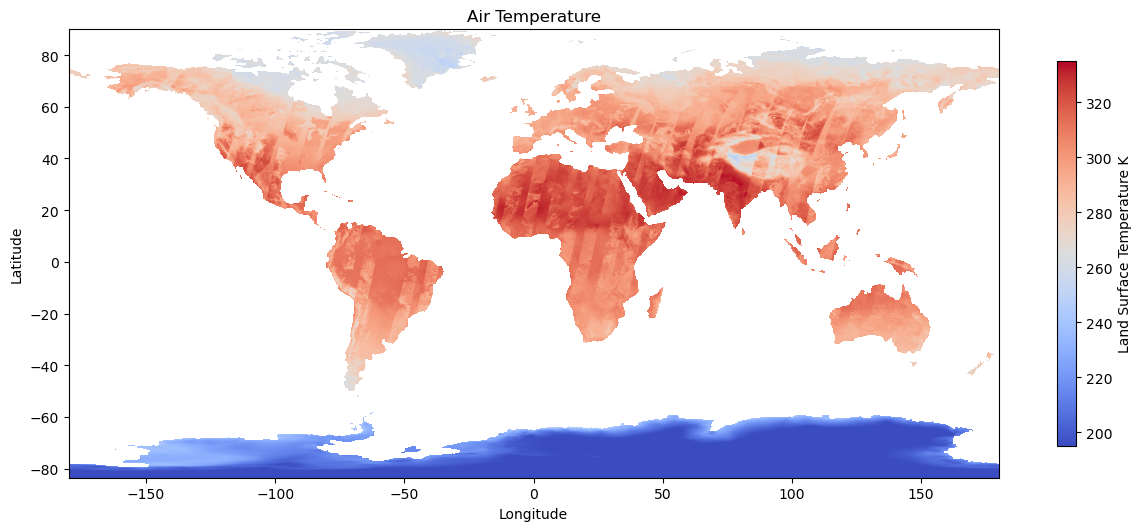

In [16]:
from ml4xcube.plotting import plot_slice

df  = pd.concat([orig["land_surface_temperature"], to_pred["land_surface_temperature"]])
lst = df.reset_index()

# Reverse latitude values & reset index
lst["lat"] = -lst["lat"] 
lst        = lst.set_index(["lat", "lon"])

ds_updated = lst.to_xarray()

plot_slice(
    ds          = ds_updated,
    var_to_plot = "land_surface_temperature",
    xdim        = "lon",
    ydim        = "lat",
    color_map   = "coolwarm",
    title       = "Air Temperature",
    label       = "Land Surface Temperature K", 
    vmin        = 195,
    vmax        = 335
)